<a href="https://colab.research.google.com/github/Wazib/Transformer_SLFN_PSCE/blob/main/Transformer_SLFN_PSCE_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Encoder Architecture with Selective Learning and Enhanced Word Representation

This code is associated with the paper:

Ansar, Wazib, Saptarsi Goswami, Amlan Chakrabarti, and Basabi Chakraborty. “A Novel Selective Learning based Transformer Encoder Architecture with Enhanced Word Representation.” Submitted to Applied Intelligence, Springer (2022).

#Downloading spaCy

In [ ]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=229b4f8c155b743029d609c87259eadecf4a11ad22faa3a1b99cdefc3d25f6ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-z379h1wo/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


# Importing Libraries


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K 
import string
import re
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords 
from nltk import word_tokenize, WordNetLemmatizer

In [ ]:
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg', parse=True, tag=True, entity=True)


#Loading Data Set

In [ ]:
# Data Set
df = pd.read_csv('Dataset.csv', engine='python',index_col=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#Pre-Processing

Adding start, end and sep token as sostoken, eostoken, septoken

In [ ]:
def special_token(ipstr):
    #Adding the start token and end token
    ipstr='sostoken '+ipstr+' eostoken'
    #Adding septoken for new sentences
    ipstr=re.sub('[.]+', ' septoken ', ipstr)
    #Checking for the case where septoken is also the eostoken
    ipstr=re.sub('septoken  eostoken', 'eostoken', ipstr)
    return ipstr

In [ ]:
#Adding the special tokens
text_special=[special_token(rev) for rev in df.review]

> Cleaning, lemmatizing and filtering length



In [ ]:
#Function for text cleaning, removing URL and 
#producing lowercase words with minimal punctuation
def cleaning(ipstr):      
    exclude = set(string.punctuation)

    # remove new line and digits with regular expression
    ipstr = re.sub(r'\n', '', ipstr)
    #ipstr = re.sub(r'\d', '', ipstr)
    # remove patterns matching url format
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    ipstr = re.sub(url_pattern, ' ', ipstr)
    # remove non-ascii characters
    ipstr = ''.join(character for character in ipstr if ord(character) < 128)
    # remove punctuations
    ipstr = ''.join(character for character in ipstr if character not in exclude)
    # standardize white space
    ipstr = re.sub(r'\s+', ' ', ipstr)

    # drop capitalization
    ipstr = ipstr.lower()
    #remove white space
    ipstr = ipstr.strip()
    
    return ipstr

def lenfilter(token_list):
#    Remove single and double characters
    return [word for word in token_list if len(word)>0]

#Lemmatizing words
lemmatizer = WordNetLemmatizer() 
def token_lemmatize(token_list):
    return [lemmatizer.lemmatize(t) for t in token_list]

In [ ]:
#Cleaning Text
text_clean=[cleaning(sen) for sen in text_special]

In [ ]:
#Tokenizing
tokens = [word_tokenize(sen) for sen in text_clean]

In [ ]:
#Filtering single and double characters
len_filtered_words = [lenfilter(sen) for sen in tokens]

In [ ]:
result = [' '.join(sen) for sen in len_filtered_words]

In [ ]:
df['Text_Final'] = result

In [ ]:
df['Tokens'] = len_filtered_words

Converting output to categorical format

In [ ]:
pos_list=[]
neg_list=[]
for i in df['sentiment']:
    if i=='positive':
        pos_list.append(1)
        neg_list.append(0)
    elif i=='negative':
        pos_list.append(0)
        neg_list.append(1)
df['pos']=pos_list
df['neg']=neg_list
label_names=['pos','neg']
y_cat=df[label_names].values

In [ ]:
df.head()

,review,sentiment,Text_Final,Tokens,pos,neg
0,One of the other reviewers has mentioned that ...,positive,sostoken one of the other reviewers has mentio...,"[sostoken, one, of, the, other, reviewers, has...",1,0
1,A wonderful little production. <br /><br />The...,positive,sostoken a wonderful little production septoke...,"[sostoken, a, wonderful, little, production, s...",1,0
2,I thought this was a wonderful way to spend ti...,positive,sostoken i thought this was a wonderful way to...,"[sostoken, i, thought, this, was, a, wonderful...",1,0
3,Basically there's a family where a little boy ...,negative,sostoken basically theres a family where a lit...,"[sostoken, basically, theres, a, family, where...",0,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,sostoken petter matteis love in the time of mo...,"[sostoken, petter, matteis, love, in, the, tim...",1,0


#Statistically Analyzing the Data

Finding the distribution of length of text

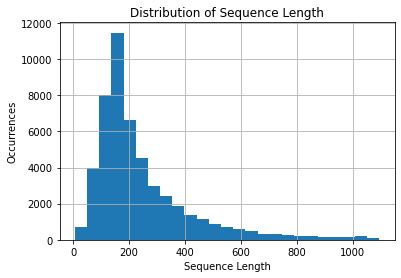

In [ ]:
text_word_count = []

# populate the lists with sentence lengths
for i in df['Text_Final']:
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count})

length_df.hist(bins = 25)
plt.xlabel('Sequence Length')  
plt.ylabel('Occurrences')  
plt.title('Distribution of Sequence Length')
plt.show()

Percentage of text having length below a specified value

In [ ]:
cnt=0
for i in df['Text_Final']:
    if(len(i.split())<=512):
        cnt=cnt+1
print(cnt/len(df['Text_Final']))

0.91592


Finding the total number of words in the corpus

In [ ]:
wcnt=0
for i in df['Text_Final']:
    wcnt+=len(i.split())
print("The total number of words are:", wcnt, sep='\t')

The total number of words are:	12273444


Fixing the maximum length of text

In [ ]:
maxlen=512

> Dictionary



In [ ]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(len_filtered_words)

Finding the size of vocabulary

In [ ]:
#total vocabulary size before filtering
print("Total vocabulary size: ", len(dictionary))

Total vocabulary size:  157008


In [ ]:
vocab_size=len(dictionary)

#Preparing the Train and Test Sets

In [ ]:
#Splitting into train and test sets
from sklearn.model_selection import train_test_split
x_tr,x_test,y_tr,y_test=train_test_split(np.array(df['Text_Final']),y_cat,test_size=0.10,random_state=21,shuffle=True)

In [ ]:
#Further splitting the train set into train and validation sets
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(x_tr,y_tr,test_size=0.10,random_state=21,shuffle=True)

#Tokenizing the Text

In [ ]:
#prepare a tokenizer for reviews
x_tokenizer = Tokenizer(num_words=vocab_size, oov_token=None) 
x_tokenizer.fit_on_texts(list(x_tr)+list(x_val)+list(x_test))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)

word_index=x_tokenizer.word_index

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=maxlen, padding='post', truncating='post')
x_val   =   pad_sequences(x_val_seq, maxlen=maxlen, padding='post', truncating='post')
x_test  =   pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

#size of vocabulary ( +1 for padding token)
#vocab_size   =  len(x_tokenizer.word_index) + 1
vocab_size+=1

#Transformer Model

## Implement multi head self attention as a Keras layer


In [ ]:

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output



## Implement a Transformer block as a layer


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)

        #Selective Learn and Forget Layer
        self.sl1=keras.Sequential(
            [layers.Dense(ff_dim, activation="sigmoid"), layers.Dense(embed_dim),])
        
        #Feed forward layer customized for Selective Learning
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="tanh"), layers.Dense(embed_dim),]
        )

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        out2=self.sl1(out1)
        ffn_output = out2*self.ffn(out1)

        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



## Implement embedding layer

Three tier embedding i. Token embedding, ii. Position Embedding iii. Part of Speech embedding


In [ ]:
#Training Word2Vec model upon the vocabulary
word2vec_model = gensim.models.Word2Vec(len_filtered_words, size=32, min_count = 1, window = 5)
word_model=word2vec_model.wv

Part of Speech tagging

In [ ]:
df.head()

,review,sentiment,Text_Final,Tokens,pos,neg
0,One of the other reviewers has mentioned that ...,positive,sostoken one of the other reviewers has mentio...,"[sostoken, one, of, the, other, reviewers, has...",1,0
1,A wonderful little production. <br /><br />The...,positive,sostoken a wonderful little production septoke...,"[sostoken, a, wonderful, little, production, s...",1,0
2,I thought this was a wonderful way to spend ti...,positive,sostoken i thought this was a wonderful way to...,"[sostoken, i, thought, this, was, a, wonderful...",1,0
3,Basically there's a family where a little boy ...,negative,sostoken basically theres a family where a lit...,"[sostoken, basically, theres, a, family, where...",0,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,sostoken petter matteis love in the time of mo...,"[sostoken, petter, matteis, love, in, the, tim...",1,0


In [ ]:
part_of_speech=[]
for x in tqdm(range(len(df['Text_Final']))):
    part_of_speech_t=[]
    if len(str(df['Text_Final'][x])) != 0:
        lines = str(df['Text_Final'][x]).split('septoken ')
        for line in lines:
            if line.find('eostoken', 0, len(line))== (-1):
                line+='septoken'
            doc = nlp(line)
            for t in doc:
                if (t.text=='sostoken') or (t.text=='eostoken') or (t.text=='septoken'):
                    part_of_speech_t.append('SPCL') #Adding POS for special token
                else:
                    part_of_speech_t.append(t.pos_)
    else:
        print("text length = 0")
    part_of_speech.append(part_of_speech_t)

100%|██████████| 50000/50000 [1:23:38<00:00,  9.96it/s]


Finding unique parts of speech

In [ ]:
unique_pos=[]
pos_dictionary = corpora.Dictionary(part_of_speech)
for k in pos_dictionary:
    unique_pos.append(pos_dictionary[k])

In [ ]:
unique_pos=['ADJ', 'ADV', 'AUX', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'SPCL', 'VERB', 'INTJ', 'SCONJ', 'CCONJ', 'ADP', 'X', 'PUNCT', 'SYM']

In [ ]:
print(unique_pos)

['ADJ', 'ADV', 'AUX', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'SPCL', 'VERB', 'INTJ', 'SCONJ', 'CCONJ', 'ADP', 'X', 'PUNCT', 'SYM']



One hot encoding the POS tokens

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(unique_pos)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[ 0  2  3  5  7  8  9 10 11 14 16  6 13  4  1 17 12 15]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Mapping one-hot encoding to POS


In [ ]:
#Mapping one-hot encoding to POS
pos_dict=dict(zip(unique_pos, onehot_encoded))

In [ ]:
word_base=word_model.vocab

Determining POS for terms in vocabulary

In [ ]:
word_pos=dict()
word_posa=dict()
for i in range(len(len_filtered_words)):
    for j in range(len(len_filtered_words[i])):
        if word_base:
            if len_filtered_words[i][j] in word_base:
                # Mapping part of speech vector
                word_pos[len_filtered_words[i][j]]=pos_dict[part_of_speech[i][j]]
                # Mapping part of speech
                word_posa[len_filtered_words[i][j]]=part_of_speech[i][j]
                word_base.pop(len_filtered_words[i][j])
        else:
            break

Part of Speech

In [ ]:
word2vec_model = gensim.models.Word2Vec(len_filtered_words, size=32, min_count = 1, window = 5)
word_model=word2vec_model.wv
word_base=word_model.vocab

POS Embedding Vector 

In [ ]:
#Preparing a list of word vectors corresponding to each part of speech

adj_list=[]
adv_list=[]
aux_list=[]
det_list=[]
noun_list=[]
num_list=[]
part_list=[]
pron_list=[]
propn_list=[]
spcl_list=[]
verb_list=[]
intj_list=[]
sconj_list=[]
cconj_list=[]
adp_list=[]
x_list=[]
punct_list=[]
sym_list=[]

for i in word_base:
    if (word_posa[i]=='ADJ'):
        adj_list.append(word_model[i])
    elif (word_posa[i]=='ADV'):
        adv_list.append(word_model[i])
    elif (word_posa[i]=='AUX'):
        aux_list.append(word_model[i])
    elif (word_posa[i]=='DET'):
        det_list.append(word_model[i])
    elif (word_posa[i]=='NOUN'):
        noun_list.append(word_model[i])
    elif (word_posa[i]=='NUM'):
        num_list.append(word_model[i])
    elif (word_posa[i]=='PART'):
        part_list.append(word_model[i])
    elif (word_posa[i]=='PRON'):
        pron_list.append(word_model[i])
    elif (word_posa[i]=='PROPN'):
        propn_list.append(word_model[i])
    elif (word_posa[i]=='SPCL'):
        spcl_list.append(word_model[i])
    elif (word_posa[i]=='VERB'):
        verb_list.append(word_model[i])
    elif (word_posa[i]=='INTJ'):
        intj_list.append(word_model[i])
    elif (word_posa[i]=='SCONJ'):
        sconj_list.append(word_model[i])
    elif (word_posa[i]=='CCONJ'):
        cconj_list.append(word_model[i])
    elif (word_posa[i]=='ADP'):
        adp_list.append(word_model[i])
    elif (word_posa[i]=='X'):
        x_list.append(word_model[i])
    elif (word_posa[i]=='PUNCT'):
        punct_list.append(word_model[i])
    elif (word_posa[i]=='SYM'):
        sym_list.append(word_model[i])


In [ ]:
#This function takes the input as a list of vectors having the same POS
# and calculates the output as the dimension-wise average of the vectors
def avg_vector(pos_type):
    avg_vec=[]
    try:
        for i in range(len(pos_type[0])):
            avg_vec_t=[]
            for j in range(len(pos_type)):
                avg_vec_t.append(pos_type[j][i])
            avg_vec_t=np.mean(avg_vec_t)
            avg_vec.append(avg_vec_t)
        return avg_vec
    except:
        avg_vec=np.zeros(32, dtype=int)
        return list(avg_vec)

In [ ]:
#Determining the POS vector
adj_pos_vector=avg_vector(adj_list)
adv_pos_vector=avg_vector(adv_list)
aux_pos_vector=avg_vector(aux_list)
det_pos_vector=avg_vector(det_list)
noun_pos_vector=avg_vector(noun_list)
num_pos_vector=avg_vector(num_list)
part_pos_vector=avg_vector(part_list)
pron_pos_vector=avg_vector(pron_list)
propn_pos_vector=avg_vector(propn_list)
spcl_pos_vector=avg_vector(spcl_list)
verb_pos_vector=avg_vector(verb_list)
intj_pos_vector=avg_vector(intj_list)
sconj_pos_vector=avg_vector(sconj_list)
cconj_pos_vector=avg_vector(cconj_list)
adp_pos_vector=avg_vector(adp_list)
x_pos_vector=avg_vector(x_list)
punct_pos_vector=avg_vector(punct_list)
sym_pos_vector=avg_vector(sym_list)

In [ ]:
#Combining POS vector as a list
pos_vector_list=[]
pos_vector_list.append(adj_pos_vector)
pos_vector_list.append(adv_pos_vector)
pos_vector_list.append(aux_pos_vector)
pos_vector_list.append(det_pos_vector)
pos_vector_list.append(noun_pos_vector)
pos_vector_list.append(num_pos_vector)
pos_vector_list.append(part_pos_vector)
pos_vector_list.append(pron_pos_vector)
pos_vector_list.append(propn_pos_vector)
pos_vector_list.append(spcl_pos_vector)
pos_vector_list.append(verb_pos_vector)
pos_vector_list.append(intj_pos_vector)
pos_vector_list.append(sconj_pos_vector)
pos_vector_list.append(cconj_pos_vector)
pos_vector_list.append(adp_pos_vector)
pos_vector_list.append(x_pos_vector)
pos_vector_list.append(punct_pos_vector)
pos_vector_list.append(sym_pos_vector)

In [ ]:
#Mapping POS vector encoding to POS
pos_dict_v=dict(zip(unique_pos, pos_vector_list))

In [ ]:
word_model1=dict()
for word in word_base:
    word_model1[word]=np.concatenate((word_model[word],pos_dict_v[word_posa[word]]))

Preparing the embedding matrix

In [ ]:
embed_dim=64 #For vector POS

In [ ]:
embedding_matrix = np.zeros((len(word_base) + 1, embed_dim))
for word in word_base:
    embedding_vector = word_model1[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[word_index[word]] = embedding_vector


In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix], input_length=maxlen)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## Classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.


In [ ]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)



In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 512, 64)     4350400     ['input_2[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 transformer_block_1 (Transform  (None, 512, 64)     25280       ['token_and_position_embedding_1[
 erBlock)                                                        0][0]',                          
                                                                  'transformer_block_1[0][0]

# Train and Evaluate


In [ ]:
K.clear_session()

In [ ]:
cp = ModelCheckpoint(filepath='trfr_best_model.h5', monitor='val_categorical_accuracy', save_weights_only=True, verbose=1, save_best_only=True, mode='max')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["categorical_accuracy"])
history = model.fit(
    x_tr, y_tr, batch_size=32, epochs=10, callbacks=[es,cp], validation_data=(x_val, y_val)
)


Epoch 1/10
1266/1266 [==============================] - ETA: 0s - loss: 0.5271 - categorical_accuracy: 0.7280
Epoch 1: val_categorical_accuracy improved from -inf to 0.82244, saving model to trfr_best_model.h5
1266/1266 [==============================] - 33s 25ms/step - loss: 0.5271 - categorical_accuracy: 0.7280 - val_loss: 0.3915 - val_categorical_accuracy: 0.8224
Epoch 2/10
1266/1266 [==============================] - ETA: 0s - loss: 0.3894 - categorical_accuracy: 0.8276
Epoch 2: val_categorical_accuracy improved from 0.82244 to 0.85244, saving model to trfr_best_model.h5
1266/1266 [==============================] - 31s 24ms/step - loss: 0.3894 - categorical_accuracy: 0.8276 - val_loss: 0.3476 - val_categorical_accuracy: 0.8524
Epoch 3/10
1264/1266 [============================>.] - ETA: 0s - loss: 0.3446 - categorical_accuracy: 0.8524
Epoch 3: val_categorical_accuracy improved from 0.85244 to 0.86222, saving model to trfr_best_model.h5
1266/1266 [==============================] - 3

# Evaluation of Accuracy

In [ ]:
y_hat=model.predict(x_test)

Converting y_val to 1D

In [ ]:
y_sent=[]
for i in y_test:
    y_sent.append(1-np.argmax(i)) #This is done to represent argmax=0 as positve and argmax=1 as negative.

In [ ]:
y_hat_sent=[]
for i in y_hat:
    y_hat_sent.append(1-np.argmax(i)) #This is done to represent argmax=0 as positve and argmax=1 as negative.

Confusion Matrix :
[[2280  132]
 [ 314 2274]]
Accuracy Score : 0.9108
Report : 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2412
           1       0.95      0.88      0.91      2588

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



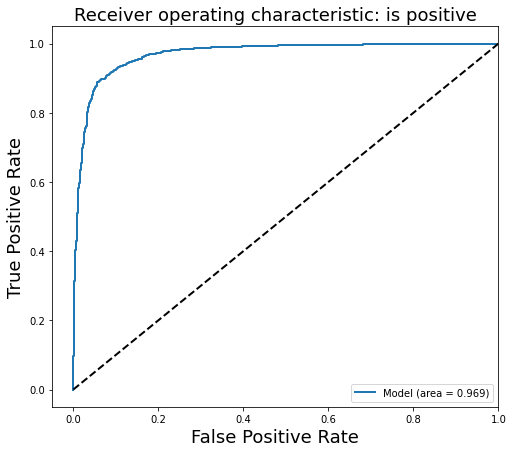

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import chain
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_sent, y_hat[:,0])
roc_auc = auc(fpr, tpr)

#This part is for the confusion matrix and accuracy score
cf_matrix = confusion_matrix(y_sent, y_hat_sent) 
print ('Confusion Matrix :')
print(cf_matrix) 
print ('Accuracy Score :',accuracy_score(y_sent, y_hat_sent))
print ('Report : ')
print (classification_report(y_sent, y_hat_sent) )
#

plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='Model (area = %0.3f)' % roc_auc, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Handling Word Inflections

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#A list of word inflections related to the word "work" present in the corpus
infl_list=['work', 'works', 'working', 'worker']

In [ ]:
X_vec=word2vec_model[infl_list]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(X_vec)

index=  0 and word= work, coordinates:- x:  6.584106 y:  -0.9820756
index=  1 and word= works, coordinates:- x:  -0.66637886 y:  4.1551967
index=  2 and word= working, coordinates:- x:  -2.5147877 y:  -1.759739
index=  3 and word= worker, coordinates:- x:  -3.402937 y:  -1.413383


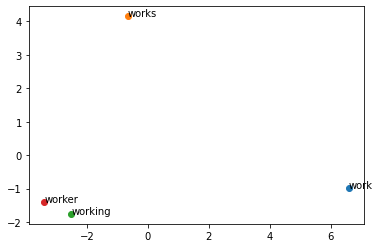

In [ ]:
#Plotting            
for i, word in enumerate(list(infl_list)):
    #Selecting the most frequent words only
    #printing the word and its enumeration
    print ("index= ",i,"and word=", word, end=', ')
    #Plotting most frequnet words in scatter plot
    plt.scatter(result[i, 0], result[i, 1])
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    print("coordinates:- x: ", result[i, 0], "y: ", result[i, 1])
#plt.yaxis.set_major_locator(mticks.MultipleLocator(.5))
#plt.xaxis.set_major_locator(mticks.MultipleLocator(.5))
plt.savefig("fig2.jpg", dpi=300)
plt.show()

# Handling Polysemy

In [ ]:
#polysemy
word_model['firm']
adj_word=np.concatenate((word_model[word],adj_pos_vector))
noun_word=np.concatenate((word_model[word],noun_pos_vector))
verb_word=np.concatenate((word_model[word],verb_pos_vector))
adv_word=np.concatenate((word_model[word],adv_pos_vector))
word_mat=np.array([adj_word, noun_word, verb_word, adv_word])

In [ ]:
pca_w = PCA(n_components=2)
pca_t = pca.fit_transform(word_mat)

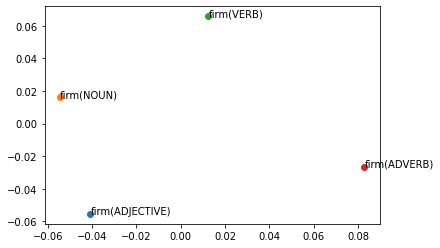

In [ ]:
#Plotting      
plt.scatter(pca_t[0, 0], pca_t[0, 1])
plt.annotate("firm(ADJECTIVE)", xy=(pca_t[0, 0], pca_t[0, 1]))
plt.scatter(pca_t[1, 0], pca_t[1, 1])
plt.annotate("firm(NOUN)", xy=(pca_t[1, 0], pca_t[1, 1]))
plt.scatter(pca_t[2, 0], pca_t[2, 1])
plt.annotate("firm(VERB)", xy=(pca_t[2, 0], pca_t[2, 1]))
plt.scatter(pca_t[3, 0], pca_t[3, 1])
plt.annotate("firm(ADVERB)", xy=(pca_t[3, 0], pca_t[3, 1]))


plt.show()

# Visualizing POS characteristics Embeddings

In [ ]:
#Specifying the unique POS present in the vocabulary
uni_pos=['ADJ', 'ADV', 'DET', 'NOUN', 'NUM', 'PRON', 'VERB', 'AUX', 'PUNCT']

In [ ]:
pos_vec=[]
for ele in uni_pos:
    pos_vec.append(pos_dict_v[ele])

In [ ]:
pos_vec=np.array(pos_vec)

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(pos_vec)

index=  0 and word= ADJ, coordinates:- x:  -0.05191104 y:  -0.08344194
index=  1 and word= ADV, coordinates:- x:  -0.07344665 y:  0.0198116
index=  2 and word= DET, coordinates:- x:  -0.030016499 y:  -0.041188136
index=  3 and word= NOUN, coordinates:- x:  -0.024097808 y:  -0.050045986
index=  4 and word= NUM, coordinates:- x:  0.17506853 y:  0.0024966975
index=  5 and word= PRON, coordinates:- x:  -0.06347727 y:  0.10103967
index=  6 and word= VERB, coordinates:- x:  -0.058692932 y:  0.026220402
index=  7 and word= AUX, coordinates:- x:  -0.073815025 y:  0.010337234
index=  8 and word= PUNCT, coordinates:- x:  0.20038861 y:  0.014770498


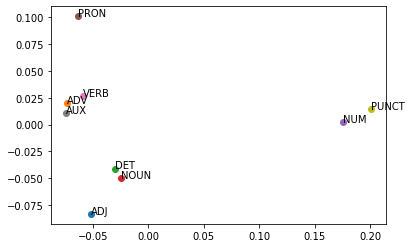

In [ ]:
#Plotting            
for i, word in enumerate(list(uni_pos)):
    #Selecting the most frequent words only
    #printing the word and its enumeration
    print ("index= ",i,"and word=", word, end=', ')
    #Plotting most frequnet words in scatter plot
    plt.scatter(result[i, 0], result[i, 1])
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    print("coordinates:- x: ", result[i, 0], "y: ", result[i, 1])
#plt.yaxis.set_major_locator(mticks.MultipleLocator(.5))
#plt.xaxis.set_major_locator(mticks.MultipleLocator(.5))
plt.savefig("fig2.jpg", figsize=(8, 6), dpi=1200)
plt.show()